In [178]:
import numpy as np
import pickle
from scipy.interpolate import CubicSpline, RectBivariateSpline
import scipy.optimize
import scipy.fft
import sys
import os
import copy
from eigenshuffle import eigenshuffle

from ode_funs import ode_itime, set_intervals, solve, fixup, propagate, wrapper
from gfile_helpers import read_gfile, write_gfile, plot_gfile
from read_stride_utils import percent_err, readWmat
from stride_process_eq import convert_efit_equilibrium, process_direct_equilibrium, Bfield, find_O_point, find_X_points
from stride_plotting_utils import plot_straight_field_line_coords, plot_profiles, plot_metric
from stride_fourfit import make_metric, make_primitive_matrices, make_coefficient_matrices

In [2]:
# os.chdir('STRIDE')
os.getcwd()

'/home/fouriest/SCHOOL/Princeton/PPPL/STRIDE'

In [3]:
"""some misc plotting parameters"""

colorblind_colors = [(0.0000, 0.4500, 0.7000), # blue
                     (0.8359, 0.3682, 0.0000), # vermillion
                     (0.0000, 0.6000, 0.5000), # bluish green
                     (0.9500, 0.9000, 0.2500), # yellow
                     (0.3500, 0.7000, 0.9000), # sky blue
                     (0.8000, 0.6000, 0.7000), # reddish purple
                     (0.9000, 0.6000, 0.0000), # orange
                     (0.5000, 0.5000, 0.5000)] # grey

dashes = [(1.0, 0.0, 0.0, 0.0, 0.0, 0.0), # solid
          (3.7, 1.6, 0.0, 0.0, 0.0, 0.0), # dashed
          (1.0, 1.6, 0.0, 0.0, 0.0, 0.0), # dotted
          (6.4, 1.6, 1.0, 1.6, 0.0, 0.0), # dot dash
          (3.0, 1.6, 1.0, 1.6, 1.0, 1.6), # dot dot dash
          (6.0, 4.0, 0.0, 0.0, 0.0, 0.0), # long dash
          (1.0, 1.6, 3.0, 1.6, 3.0, 1.6)] # dash dash dot
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rcParams, cycler
%matplotlib inline
matplotlib.rcdefaults()
rcParams['font.family'] = 'DejaVu Serif'
rcParams['mathtext.fontset'] = 'cm'
rcParams['font.size'] = 12
rcParams['figure.facecolor'] = (1,1,1,1)
rcParams['figure.figsize'] = (10,4)
rcParams['figure.dpi'] = 141
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['axes.labelsize'] =  'small'
rcParams['axes.titlesize'] = 'medium'
rcParams['lines.linewidth'] = 2.5
rcParams['lines.solid_capstyle'] = 'round'
rcParams['lines.dash_capstyle'] = 'round'
rcParams['lines.dash_joinstyle'] = 'round'
rcParams['xtick.labelsize'] = 'x-small'
rcParams['ytick.labelsize'] = 'x-small'
rcParams['legend.fontsize'] = 'small'
# rcParams['text.usetex']=True
color_cycle = cycler(color=colorblind_colors)
dash_cycle = cycler(dashes=dashes)
rcParams['axes.prop_cycle'] =  color_cycle

labelsize=10
ticksize=8

In [4]:
os.getcwd()

'/home/fouriest/SCHOOL/Princeton/PPPL/STRIDE'

In [5]:
os.chdir('..')

In [84]:
gfiles = os.listdir('gfiles')
print(gfiles)
gfile_dir = './gfiles/'
g = read_gfile(gfile_dir + gfiles[4])
# print(g['shot'],g['time'])

['g174082.03000', 'g180465.03720_250', 'g163518.4006', 'g150610.04000', 'g174823.04000', 'g176868.997', 'g174080.04000', 'g150610.03600', 'g174446.03390', 'g150610.03700', 'g150610.03900', 'g174080.03549', 'g150610.03800', 'g150610.03500', 'g150792.2201', 'g174082.04000', 'g174082.04505', 'g174823.03000', '.ipynb_checkpoints', 'g174080.03000']


In [108]:
psi_grid, theta_grid, straight_field_line_coords, profiles, \
                ro, zo, psio, straight_field_line_coords_arrs, profiles_arrs, bf, temp_data = convert_efit_equilibrium(g, mpsi=257,mtheta=257,psilow=0.01,psihigh=0.98,return_arrs=True)

In [109]:
nn=1
delta_mlow = 20
delta_mhigh = 20
mlow = np.min(nn*profiles_arrs['q'].min(),0) - 4 - delta_mlow
mhigh = nn*profiles_arrs['q'].max() + delta_mhigh
m_grid = np.arange(mlow,mhigh+1).astype(int)
mpert = mhigh-mlow+1

In [110]:
metric, fourfit_metric = make_metric(psi_grid, theta_grid, m_grid, ro, zo, straight_field_line_coords)

In [111]:
primitive_matrices = make_primitive_matrices(psi_grid,m_grid,nn,psio,profiles,fourfit_metric)

In [112]:
coeffs, coeff_splines = make_coefficient_matrices(psi_grid,m_grid,nn,psio,profiles,fourfit_metric)

In [113]:
coeffs.keys()

dict_keys(['F', 'Fbar', 'G', 'K', 'Kbar', 'Q'])

In [114]:
FinvK = coeffs['Q'] @ np.linalg.inv(coeffs['Fbar']) @ coeffs["Kbar"]

In [115]:
G = coeffs["G"]
KFinvK = coeffs["Kbar"].conj().transpose((0,2,1)) @ np.linalg.inv(coeffs['Fbar']) @ coeffs['Kbar']

In [116]:
eig1 = np.linalg.eig(FinvK)[0]

In [117]:
eig2 = np.linalg.eig(KFinvK)[0]
eigG = np.linalg.eig(G)[0]
eig4 = np.linalg.eig(G-KFinvK)[0]

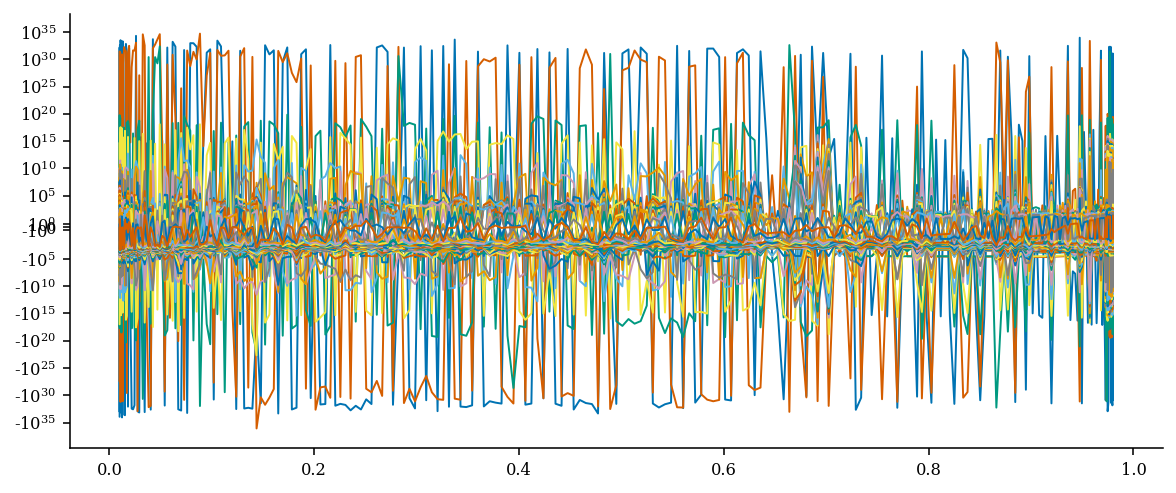

In [118]:
plt.plot(psi_grid, eig1.real, lw=1);
plt.yscale('symlog')

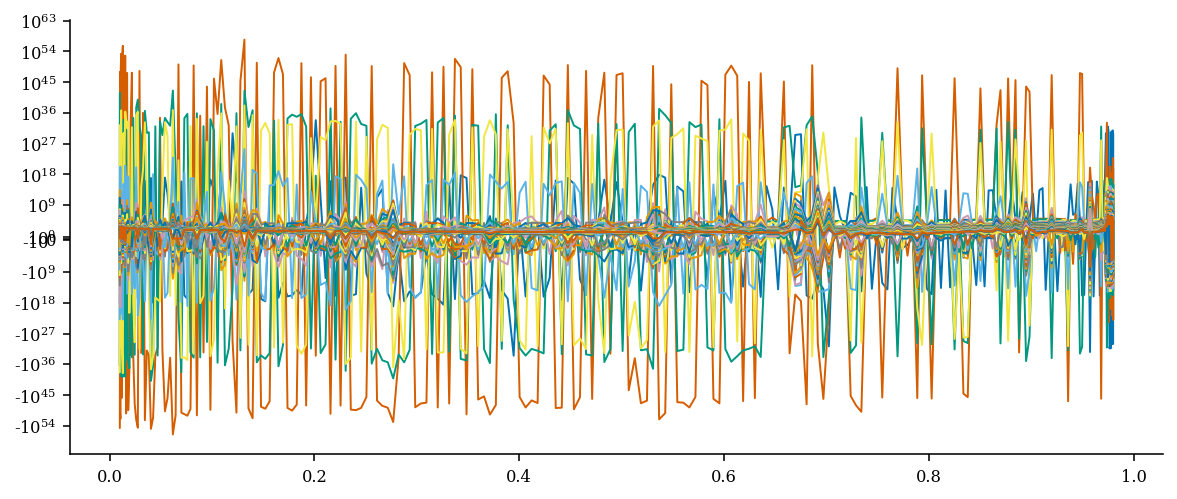

In [120]:
plt.plot(psi_grid, eig2.real, lw=1);
plt.yscale('symlog')

In [134]:
e = np.linalg.eigh(fourfit_metric['G23'])[0]
print(e.min(), e.max())

-23.1725171574386 7.65418652645045


In [129]:
y = fourfit_metric['G23'] - fourfit_metric['G23'].conj().transpose(0,2,1)
abs(y).max()

0.0

In [135]:
with open('gfiles.pkl','rb') as f:
    gfiles = pickle.load(f)

In [137]:
samples = np.array(list(gfiles.keys()))

In [147]:
samples = np.array(list(data.keys()))

In [139]:
with open('integrator_test_data.pkl','rb') as f:
    data = pickle.load(f)

In [285]:
data[sample]['sing'][:,-1].min()

2.0

In [287]:
for i, sample in enumerate(samples):
    print(i, sample, data[sample]['sing'][:,-1].min(), min(np.linalg.eigh(data[sample]['Wp_dcon'])[0]))

0 g174082.03000 1.0 -2.5034265704241
1 g180465.03720_250 1.0 0.22691836008020716
2 g163518.4006 1.0 -0.13388478746844182
3 g150610.04000 1.0 -2.0410744694834664
4 g174823.04000 2.0 -2.8934805036323263
5 g176868.997 2.0 0.2040201357239331
6 g174080.04000 1.0 -714.2982850882756
7 g178969.03702_250 2.0 0.6190243524901778
8 g150610.03600 1.0 -4.736110876082154
9 g174446.03390 2.0 -4.814960572086788
10 g150610.03700 1.0 -5.083571867669363
11 g150610.03900 1.0 -2.1447520313714246
12 g174080.03549 1.0 -3.6521298658475225
13 g150610.03800 1.0 -4.826612739748056
14 g150610.03500 1.0 -5.165271365658668
15 g150792.2201 2.0 -84.85926853958892
16 g174082.04000 1.0 -4.201475680431966
17 g174082.04505 2.0 -4.3749166949021845
18 g174823.03000 2.0 -3.1691370195216586
19 g174080.03000 2.0 -2.532149653305456


In [266]:
sample = samples[7] # 5, 7

for i, sample in enumerate(samples):

    psi = data[sample]['coefficient_matrices']['psi_grid']
    F = data[sample]['coefficient_matrices']['F']
    Fbar = data[sample]['coefficient_matrices']['Fbar']
    K = data[sample]['coefficient_matrices']['K']
    Kbar = data[sample]['coefficient_matrices']['Kbar']
    Q = data[sample]['coefficient_matrices']['Q']
    G = data[sample]['coefficient_matrices']['G']
    FinvK = Q @ np.linalg.inv(Fbar) @ Kbar
    KFinvK = Kbar.conj().transpose(0,2,1) @ np.linalg.inv(Fbar) @ Kbar

    eig1 = np.linalg.eig(FinvK)[0]
    eig2 = np.linalg.eigh(KFinvK)[0]
    eig3 = np.linalg.eigh(G-KFinvK)[0]

    allneg = np.all(np.min(eig3, axis=1) < 0)
    print(i, allneg, min(np.linalg.eigh(data[sample]['Wp_dcon'])[0]))

0 True -2.5034265704241
1 False 0.22691836008020716
2 True -0.13388478746844182
3 True -2.0410744694834664
4 True -2.8934805036323263
5 True 0.2040201357239331
6 True -714.2982850882756
7 False 0.6190243524901778
8 True -4.736110876082154
9 True -4.814960572086788
10 True -5.083571867669363
11 True -2.1447520313714246
12 True -3.6521298658475225
13 True -4.826612739748056
14 True -5.165271365658668
15 False -84.85926853958892
16 True -4.201475680431966
17 True -4.3749166949021845
18 True -3.1691370195216586
19 True -2.532149653305456


In [280]:
sample = samples[7]

psi = data[sample]['coefficient_matrices']['psi_grid']
F = data[sample]['coefficient_matrices']['F']
Fbar = data[sample]['coefficient_matrices']['Fbar']
K = data[sample]['coefficient_matrices']['K']
Kbar = data[sample]['coefficient_matrices']['Kbar']
Q = data[sample]['coefficient_matrices']['Q']
G = data[sample]['coefficient_matrices']['G']
FinvK = Q @ np.linalg.inv(Fbar) @ Kbar
KFinvK = Kbar.conj().transpose(0,2,1) @ np.linalg.inv(Fbar) @ Kbar


eig1 = eigenshuffle(FinvK, op=np.linalg.eig)[0]
eig2 = eigenshuffle(KFinvK, op=np.linalg.eigh)[0]
eig3 = eigenshuffle(G-KFinvK, op=np.linalg.eigh)[0]


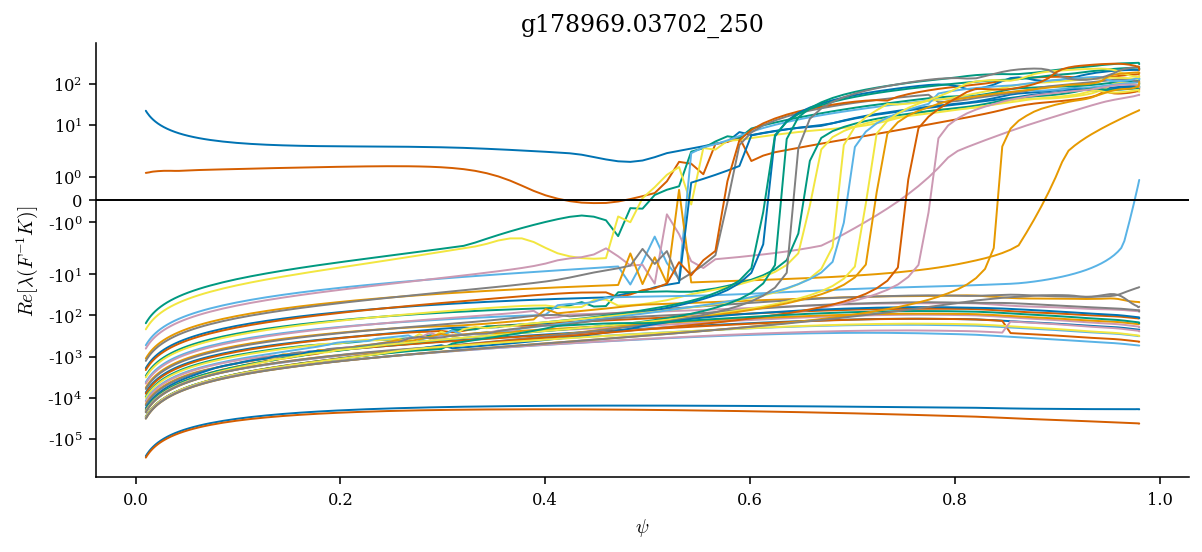

In [281]:
plt.plot(psi, eig1.real, lw=1);
plt.yscale('symlog')
plt.axhline(0,c='k', lw=1)
plt.title(sample)
plt.xlabel('$\psi$')
plt.ylabel('$Re[\lambda(F^{-1}K)]$');

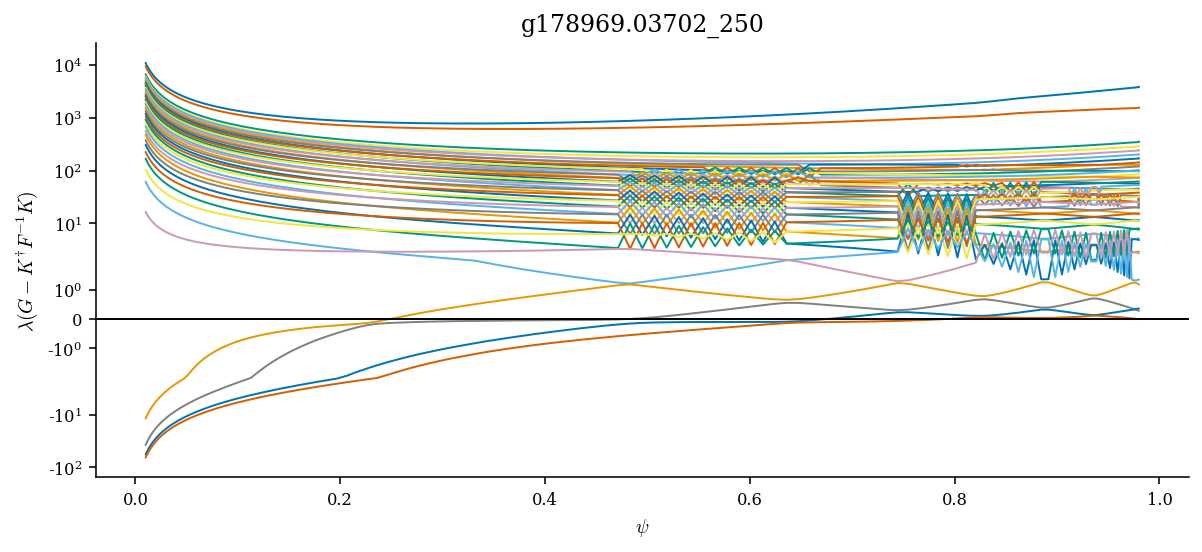

In [282]:
plt.plot(psi, eig3.real, lw=1);
plt.yscale('symlog')
plt.axhline(0,c='k', lw=1)
plt.title(sample)
plt.xlabel('$\psi$')
plt.ylabel('$\lambda(G-K^{\dagger}F^{-1}K)$');

In [149]:
data[sample]['coefficient_matrices'].keys()

dict_keys(['psi_grid', 'F', 'Fbar', 'G', 'K', 'Kbar', 'Q'])

In [ ]:
def local_cubic_2d(x, y, xg, yg, fg, dx=0, dy=0, grid=False):
    """Piecewise cubic Hermite interpolation using local splines
    Args:
        x (array-like): x values where interpolated function 
            values are desired
        y (array-like): y values where interpolated function 
            values are desired
        xg (array-like): Locations of known function values
        yg (array-like): Locations of known function values
        fg (array-like): Known function values at locations 
            given by xg, yg
        dx (int): order of derivative in x
        dy (int): order of derivative in y
    Returns:
        f (numpy array): Values of interpolated function at 
            desired locations 
    """
    # sanitize inputs
    x = np.asarray(x).flatten()
    y = np.asarray(y).flatten()
    
#     xg = np.asarray(xg).flatten()
#     fg = np.asarray(fg).flatten()
    Nx = xg.size
    Ny = yg.size
    
    assert all(x>=xg.min()) and all(x<=xg.max()) and all(y>=yg.min()) and all(y<=yg.max())
    
    # sort arrays
    idx = np.argsort(x)
    idy = np.argsort(y)
    outidx = np.argsort(idx)
    outidy = np.argsort(idy)
    x = x[idx]
    y = y[idy]
    gidx = np.argsort(xg)
    gidy = np.argsort(yg)
    xg = xg[gidx]
    yg = yg[gidy]
    fg = fg[gidx,gidy]
    
    # some fancy indexing
    i = np.searchsorted(xg,x) - 1
    im1 = i-1
    im1[im1<0] = 2
    ip1 = i+1
    ip2 = i+2
    ip2[ip2>Nx-1] = Nx-3
    
    j = np.searchsorted(yg,y) - 1
    jm1 = j-1
    jm1[jm1<0] = 2
    jp1 = j+1
    jp2 = j+2
    jp2[jp2>Ny-1] = Ny-3
    
    
    # compute deltas
    dx_ip2_ip1 = np.expand_dims(xg[ip2] - xg[ip1],[ii+1 for ii in range(fg.ndim-1)])
    dx_ip1_i = np.expand_dims(xg[ip1] - xg[i],[ii+1 for ii in range(fg.ndim-1)])
    dx_i_im1 = np.expand_dims(xg[i] - xg[im1],[ii+1 for ii in range(fg.ndim-1)])

    dy_jp2_jp1 = np.expand_dims(yg[jp2] - yg[jp1],[ii+1 for ii in range(fg.ndim-1)])
    dy_jp1_j = np.expand_dims(yg[jp1] - yg[j],[ii+1 for ii in range(fg.ndim-1)])
    dy_j_jm1 = np.expand_dims(yg[j] - yg[jm1],[ii+1 for ii in range(fg.ndim-1)])

    
    
#     im1,jp2 ---- i,jp2 ---- ip1,jp2 ---- ip2,jp2
#        |          |            |            |
#     im1,jp1 ---- i,jp1 ---- ip1,jp1 ---- ip2,jp1
#        |          |     x,y    |            |
#     im1,j ------ i,j ------ ip1,j ------ ip2,j
#        |          |            |            |
#     im1,jm1 -- im1,j ------ ip1,jm1 ---- ip2,jm1   
    
    # values at corners of grid
    f_i_j = fg[i,j]
    f_i_jp1 = fg[i,jp1]
    f_ip1_j = fg[ip1,j]
    f_ip1_jp1 = fg[ip1,jp1]
 
    # x derivatives at corners of grid
    dfx_i_j = 



    dxjplushalf = np.squeeze(dxjplushalf)
    # evaluate splines
    if nu==0:
        t = (x - xg[j])/dxjplushalf
        h00 = (1+2*t)*(1-t)**2
        h01 = t**2*(3-2*t)
        h10 = t*(1-t)**2
        h11 = t**2*(t-1)
    elif nu==1:
        t = (x - xg[j])/dxjplushalf
        h00 = (2*(1 - t)**2 - (1 + 2*t)*2*(1-t))/dxjplushalf
        h01 = (2*t*(3-2*t) -2*t**2)/dxjplushalf
        h10 = ((1-t)**2 - 2*t*(1-t))/dxjplushalf
        h11 = (2*t*(t-1) + t**2)/dxjplushalf
    else:
        raise NotImplementedError
    
    h00 = np.expand_dims(h00,[i+1 for i in range(fg.ndim-1)])
    h01 = np.expand_dims(h01,[i+1 for i in range(fg.ndim-1)])
    h10 = np.expand_dims(h10,[i+1 for i in range(fg.ndim-1)])
    h11 = np.expand_dims(h11,[i+1 for i in range(fg.ndim-1)])
    
    g = fj*h00 + fjp1*h01 + dfj*h10 + dfjp1*h11
    return g[outidx]
    

In [204]:
def local_cubic_1d(x,xg,fg, nu=0):
    """Piecewise cubic Hermite interpolation using local splines
    Args:
        x (array-like): x values where interpolated function 
            values are desired
        xg (array-like): Locations of known function values
        fg (array-like): Known function values at locations 
            given by xg
        nu (int): order of derivative
    Returns:
        f (numpy array): Values of interpolated function at 
            desired locations 
    """
    # sanitize inputs
    fshp = np.asarray(fg).shape
    x = np.asarray(x).flatten()
#     xg = np.asarray(xg).flatten()
#     fg = np.asarray(fg).flatten()
    N = xg.size
    
    assert all(x>=xg.min()) and all(x<=xg.max())
    
    # sort arrays
    idx = np.argsort(x)
    outidx = np.argsort(idx)
    x = x[idx]
    gidx = np.argsort(xg)
    xg = xg[gidx]
    fg = fg[gidx]
    
    # some fancy indexing
    j = np.searchsorted(xg,x) - 1
    jm1 = j-1
    jm1[jm1<0] = 2
    jp1 = j+1
    jp2 = j+2
    jp2[jp2>N-1] = N-3
    
    # compute deltas
    dxjplus3half = np.expand_dims(xg[jp2] - xg[jp1],[i+1 for i in range(fg.ndim-1)])
    dxjplushalf = np.expand_dims(xg[jp1] - xg[j],[i+1 for i in range(fg.ndim-1)])
    dxjminushalf = np.expand_dims(xg[j] - xg[jm1],[i+1 for i in range(fg.ndim-1)])
    
    # estimate derivatives
    fj = fg[j]
    fjp1 = fg[jp1]
    fjm1 = fg[jm1]
    fjp2 = fg[jp2]
    dfj = dxjplushalf*(dxjplushalf/(dxjminushalf + dxjplushalf)*((fj - fjm1)/dxjminushalf) \
                       + dxjminushalf/(dxjminushalf + dxjplushalf)*((fjp1 - fj)/dxjplushalf))
    dfjp1 = dxjplushalf*(dxjplus3half/(dxjplus3half + dxjplushalf)*((fjp1 - fj)/dxjplushalf) \
                         + dxjplushalf/(dxjplus3half + dxjplushalf)*((fjp2 - fjp1)/dxjplus3half))

    dxjplushalf = np.squeeze(dxjplushalf)
    # evaluate splines
    if nu==0:
        t = (x - xg[j])/dxjplushalf
        h00 = (1+2*t)*(1-t)**2
        h01 = t**2*(3-2*t)
        h10 = t*(1-t)**2
        h11 = t**2*(t-1)
    elif nu==1:
        t = (x - xg[j])/dxjplushalf
        h00 = (2*(1 - t)**2 - (1 + 2*t)*2*(1-t))/dxjplushalf
        h01 = (2*t*(3-2*t) -2*t**2)/dxjplushalf
        h10 = ((1-t)**2 - 2*t*(1-t))/dxjplushalf
        h11 = (2*t*(t-1) + t**2)/dxjplushalf
    else:
        raise NotImplementedError
    
    h00 = np.expand_dims(h00,[i+1 for i in range(fg.ndim-1)])
    h01 = np.expand_dims(h01,[i+1 for i in range(fg.ndim-1)])
    h10 = np.expand_dims(h10,[i+1 for i in range(fg.ndim-1)])
    h11 = np.expand_dims(h11,[i+1 for i in range(fg.ndim-1)])
    
    g = fj*h00 + fjp1*h01 + dfj*h10 + dfjp1*h11
    return g[outidx]
    

In [205]:
class spline1d():
    def __init__(self, x, f, axis=0, bc_type=None):
        self.x = x
        self.f = f
        self.axis = axis
        self.bc_type = bc_type
        
    def __call__(self, x, nu=0):
        return local_cubic_1d(x,self.x,self.f, nu)
        
class spline2d():
    def __init__(self, x, y, f, bc_type_x=None, bc_type_y=None):
        self.x = x
        self.y = y
        self.f = f

In [216]:
mpsi = alldata[sample]['mpsi'] + 1
mtheta = alldata[sample]['mtheta'] + 1
psilow = alldata[sample]['profiles']['psi_grid'].min()
psihigh = alldata[sample]['profiles']['psi_grid'].max()
nn = alldata[sample]['nn']
mlow = alldata[sample]['m_grid'].min()
mhigh = alldata[sample]['m_grid'].max()
mpert = alldata[sample]['M']
m_grid = alldata[sample]['m_grid']

# splinetype1d = CubicSpline
splinetype1d = spline1d

In [217]:
temp_out = convert_efit_equilibrium(g, mpsi=mpsi, mtheta=mtheta, psilow=psilow, psihigh=psihigh, return_arrs=True,splinetype1d=splinetype1d)

psi_grid = temp_out[0]
theta_grid = temp_out[1]
straight_field_line_coords = temp_out[2]
profiles = temp_out[3]
ro = temp_out[4]
zo = temp_out[5]
psio = temp_out[6]
straight_field_line_coords_arrs = temp_out[7]
profiles_arrs = temp_out[8]
bf = temp_out[9]
temp_data = temp_out[10]

In [219]:
#plot_straight_field_line_coords(**straight_field_line_coords_arrs);

In [89]:
os.getcwd()

'/home/fouriest/SCHOOL/Princeton/PPPL'

In [90]:
g = read_gfile('STRIDE/gfiles/g178965.00741')
plot_gfile(g);

ValueError: cannot reshape array of size 235 into shape (117,2)

In [211]:

sample = samples[0]
gfile_dir = './gfiles/'
g = read_gfile(gfile_dir + sample)
print(g['shot'],g['time'])


mpsi = alldata[sample]['mpsi'] + 1
mtheta = alldata[sample]['mtheta'] + 1
psilow = alldata[sample]['profiles']['psi_grid'].min()
psihigh = alldata[sample]['profiles']['psi_grid'].max()
nn = alldata[sample]['nn']
mlow = alldata[sample]['m_grid'].min()
mhigh = alldata[sample]['m_grid'].max()
mpert = alldata[sample]['M']
m_grid = alldata[sample]['m_grid']

splinetype1d = CubicSpline


163518 4005


In [212]:
def rk4_int(fun,t0,t1,y0,nsteps, args=None):
    h = (t1-t0)/nsteps
    if args is not None:
        fun = lambda t, x, fun=fun: fun(t, x, *args)
    
    y = np.full((nsteps,*y0.shape),np.nan)
    y[0] = y0
    t = np.full(nsteps,np.nan)
    t[0] = t0
    
    for i in range(nsteps-1):
        k1 = h*fun(t[i], y[i]).reshape(y0.shape)
        k2 = h*fun(t[i] + h/2, y[i] + k1/2).reshape(y0.shape)
        k3 = h*fun(t[i] + h/2, y[i] + k2/2).reshape(y0.shape)
        k4 = h*fun(t[i] + h, y[i] + k3).reshape(y0.shape)
        y[i+1] = y[i] + 1/6*(k1 + 2*k2 + 2*k3 + k4)
        t[i+1] = t[i] + h
    return t, y


def ab4_int(fun, t0, t1, y0, nsteps, args=None):
    h = (t1-t0)/nsteps

    if args is not None:
        fun = lambda t, x, fun=fun: fun(t, x, *args)
            
    y = np.full((nsteps,*y0.shape),np.nan)
    y[0] = y0
    t = np.full(nsteps,np.nan)
    t[0] = t0
    k1 = np.full((nsteps,*y0.shape),np.nan)
    
    # not self starting, use rk4 for initial steps
    for i in range(3):
        k1[i] = h*fun(t[i], y[i]).reshape(y0.shape)
        k2 = h*fun(t[i] + h/2, y[i] + k1[i]/2).reshape(y0.shape)
        k3 = h*fun(t[i] + h/2, y[i] + k2[i]/2).reshape(y0.shape)
        k4 = h*fun(t[i] + h, y[i] + k3).reshape(y0.shape)
        y[i+1] = y[i] + 1/6*(k1[i] + 2*k2 + 2*k3 + k4).reshape(y0.shape)
        t[i+1] = t[i] + h
    
    for i in range(3,nsteps-1):
        k1[i] = h*fun(t[i], y[i]).reshape(y0.shape)
        y[i+1] = y[i] + 55/24*k1[i] - 59/24*k1[i-1] + 37/24*k1[i-2] - 9/24*k1[i-3]
        t[i+1] = t[i] + h
        
    return t, y


In [213]:
def direct_fl_int_vectorized(psi_grid,bf,ro,zo,r_sep_out,psio,power_bp,power_b,power_r, method='RK45', rtol=1e-8, atol=1e-8, nsteps=250):

    psi = psio*(1-psi_grid)
    r = ro + np.sqrt(psi_grid)*(r_sep_out-ro)
    z = zo
    
    def psi_diff(r):
        return psi - bf.psi(r,z)

    out = scipy.optimize.root(psi_diff,x0=r,tol=1e-12)
    if out.success:
        r = out.x
    else:
        raise Exception('Could not find starting pt on flux surface')

    y0 = np.zeros((len(psi_grid),4))
    y0[:,1] = np.sqrt((r-ro)**2 + (z-zo)**2)
    
    
    if method in ['RK45', 'RK23', 'LSODA', 'Radau', 'BDF']:
        out = scipy.integrate.solve_ivp(direct_fl_der_vectorized,
                                        [0,2*np.pi],
                                        y0.flatten(), 
                                        method=method,
                                        vectorized=True,
                                        rtol=rtol,
                                        atol=atol,
                                        args=(bf,ro,zo,power_bp,power_b,power_r))
        if out.success:
            eta = out.t
            y_out = out.y.T.reshape(out.t.size,-1,4)
        else:
            raise Exception('Could not integrate along flux surface')
    elif method == 'rk4':
        eta, y_out = rk4_int(direct_fl_der_vectorized,0,2*np.pi, y0, nsteps, args=(bf,ro,zo,power_bp,power_b,power_r))
    elif method == 'ab4':
        eta, y_out = ab4_int(direct_fl_der_vectorized,0,2*np.pi, y0, nsteps, args=(bf,ro,zo,power_bp,power_b,power_r))
    
    return eta, y_out
        
def direct_fl_der_vectorized(eta,y,bf,ro,zo,power_bp,power_b,power_r):
        
    y = y.reshape((-1,4))
    dy = np.zeros_like(y)
    
    cos_eta = np.cos(eta)
    sin_eta = np.sin(eta)
    
    r = y[:,1]
    R = ro + r*cos_eta
    Z = zo + r*sin_eta

    Br = bf.Br(R,Z,grid=False)
    Bz = bf.Bz(R,Z,grid=False)
    
    Bp = np.sqrt(Br**2 + Bz**2) if power_bp else 1
    Bt = bf.Bt(R,Z,grid=False) if power_b else 1
    B = np.sqrt(Bp**2 + Bt**2) if power_b else 1
    jac=Bp**power_bp * B**power_b / R**power_r
    
    dy[:,0] = r/(Bz*cos_eta - Br*sin_eta)
    dy[:,1] = dy[:,0]*(Br*cos_eta + Bz*sin_eta)
    dy[:,2] = dy[:,0]/(R**2)
    dy[:,3] = dy[:,0]*jac
    
    return dy.flatten()

In [236]:
mu0 = np.pi*4e-7

R_grid = np.linspace(g['rleft'],g['rleft']+g['rdim'],g['nw'])
Z_grid = np.linspace(-g['zdim']/2,g['zdim']/2,g['nh'])
psio = g['boundary_flux'] - g['axis_flux']
psigrid_in = np.linspace(0,1,g['nw'])
fpol = np.abs(g['fpol'])
pres = np.maximum(g['pres']*mu0,0)
qpsi = g['qpsi']
psirz_arr = g['boundary_flux'] - g['psirz']
if psio<0:
    psio = -psio
    psirz_arr = -psirz_arr
    

psirz = RectBivariateSpline(R_grid,Z_grid,psirz_arr.T)
P = splinetype1d(psigrid_in,pres)
F = splinetype1d(psigrid_in,fpol)

psi_grid = psilow + (psihigh-psilow)*np.sin(np.linspace(0,1,mpsi)*np.pi/2)**2
theta_grid = np.linspace(0,1,mtheta)
straight_field_line_coords_arrs = {'r_squared':np.zeros((mpsi,mtheta)),
                                   'delta_eta':np.zeros((mpsi,mtheta)),
                                   'delta_phi':np.zeros((mpsi,mtheta)),
                                   'jac':np.zeros((mpsi,mtheta))}

profiles_arrs = {'F':np.zeros(mpsi),
                 'P':np.zeros(mpsi),
                 'jac': np.zeros(mpsi),
                 'q': np.zeros(mpsi)}

bf = Bfield(psirz,F,P,psio)

ro,zo = find_O_point(bf)
r_sep_in, r_sep_out = find_X_points(bf,ro,zo)


power_bp = 0
power_b = 0
power_r = 0

eta, y_out = direct_fl_int_vectorized(psi_grid,bf,ro,zo,r_sep_out,psio,power_bp,power_b,power_r,method='ab4',nsteps=1000)

theta_n = y_out[:,:,3]/y_out[-1,:,3]
r_squared = y_out[:,:,1]**2
delta_eta = eta[:,np.newaxis]/(2*np.pi) - theta_n
delta_phi = F(psi_grid).squeeze()*(y_out[:,:,2] - theta_n*y_out[-1,:,2])
jac = y_out[:,:,0]/y_out[-1,:,0] - theta_n

profiles_arrs['F'] = F(psi_grid).squeeze()*2*np.pi
profiles_arrs['P'] = P(psi_grid).squeeze()
profiles_arrs['jac'] = y_out[-1,:,0]*2*np.pi*psio
profiles_arrs['q'] = y_out[-1,:,2]*F(psi_grid).squeeze()/(2*np.pi)

temp_data = np.stack([r_squared,delta_eta,delta_phi,jac],axis=2)
temp_data[-1,:,:] = temp_data[0,:,:]

for ipsi in range(mpsi):

    temp_spline = splinetype1d(theta_n[:,ipsi],temp_data[:,ipsi,:],axis=0,bc_type='periodic')
    temp_out = temp_spline(theta_grid)
    temp_out_der = temp_spline(theta_grid, nu=1)
    straight_field_line_coords_arrs['r_squared'][ipsi,:] = temp_out[:,0]
    straight_field_line_coords_arrs['delta_eta'][ipsi,:] = temp_out[:,1]
    straight_field_line_coords_arrs['delta_phi'][ipsi,:] = temp_out[:,2]
    straight_field_line_coords_arrs['jac'][ipsi,:] = (1 + temp_out_der[:,3])*y_out[-1,ipsi,0]*2*np.pi*psio


straight_field_line_coords = {key:RectBivariateSpline(psi_grid,theta_grid,val) 
                              for key,val in straight_field_line_coords_arrs.items()}
profiles = {key:splinetype1d(psi_grid,val) for key,val in profiles_arrs.items()}

straight_field_line_coords_arrs['psi_grid'] = psi_grid
straight_field_line_coords_arrs['theta_grid'] = theta_grid
profiles_arrs['psi_grid'] = psi_grid

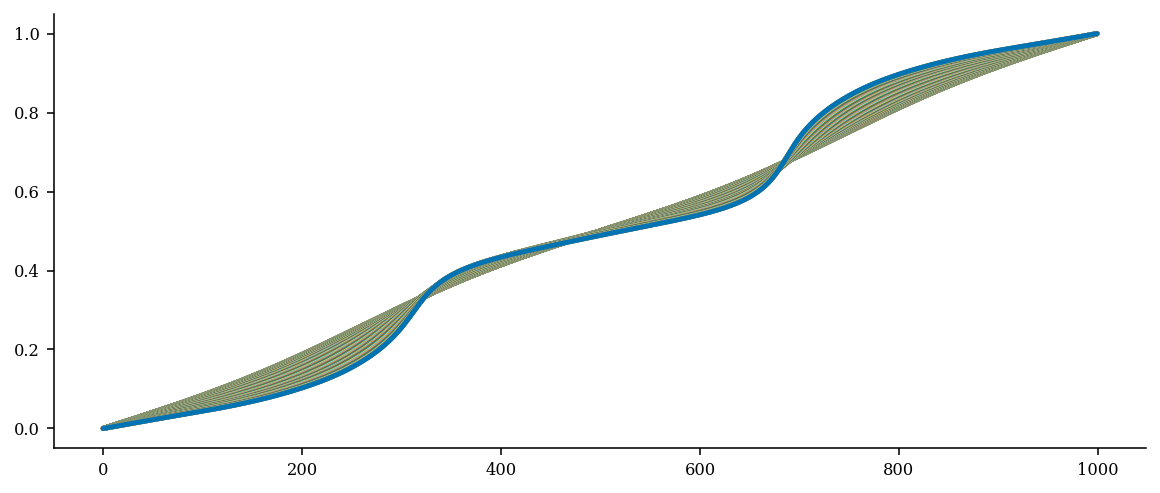

In [237]:
plt.plot(theta_n);

In [238]:
cos_eta = np.cos(eta)[:,np.newaxis]
sin_eta = np.sin(eta)[:,np.newaxis]

r = y_out[:,:,1]
R = ro + r*cos_eta
Z = zo + r*sin_eta

p = bf.psi(R,Z,grid=False)
err = np.abs((p - psio*(1-psi_grid)))/np.abs(p)*100

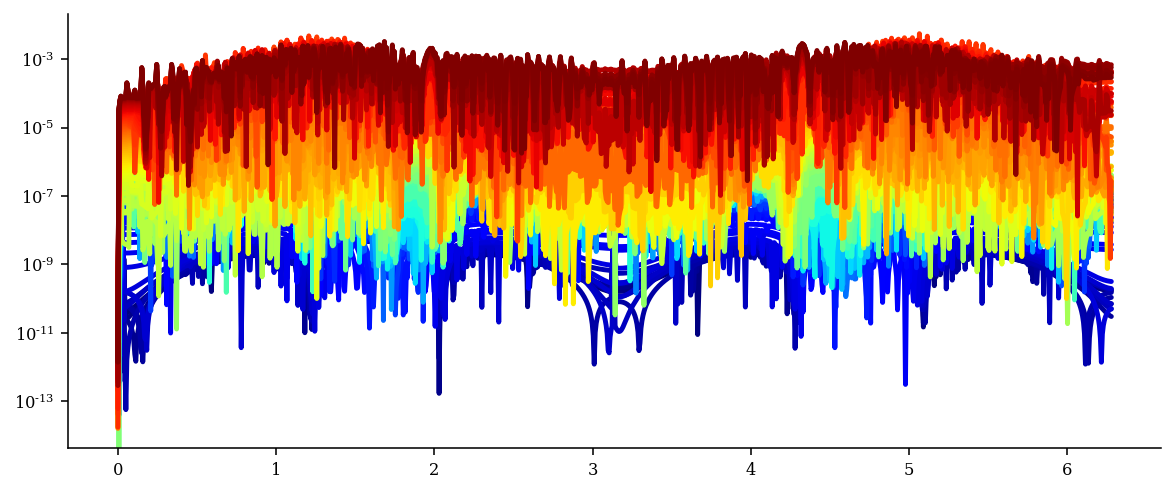

In [239]:
colors = plt.cm.jet(np.linspace(0,1,err.shape[1]))
for i in range(err.shape[1]):
    plt.semilogy(eta,err[:,i],color=colors[i]);

In [240]:
metric, fourfit_metric = make_metric(psi_grid, theta_grid, m_grid,ro,zo,straight_field_line_coords)

In [241]:
#plot_metric(psi_grid,theta_grid,metric,fft=True);

In [242]:
primitive_matrices = make_primitive_matrices(psi_grid,m_grid,nn,psio,profiles,fourfit_metric)

In [243]:
coeff_matrices, coeff_splines = make_coefficient_matrices(psi_grid,m_grid,nn,psio,profiles,
                                                          fourfit_metric,primitive_matrices, 
                                                          splinetype1d=splinetype1d)

In [244]:
itime_coeffs = np.array([39695,212830,17147,470710,1646,4683])
itime_coeffs2 = np.array([ 41680.548, 212830.2  ,  17147.72 , 470710.3  ,   1646.901,  4683.234])

# number of intervals
nInters = 500
# one of ['rk4','rk2','forward_euler','backward_euler','trapz','implicit_midpoint','expm','eig_expm', 'RK45', 'RK23','Radau','BDF','LSODA']
ode_method = 'implicit_midpoint'
# one of ['naive','sing'] (naive means equally spaced intervals/steps, sing means optimized for small steps in stiffer regions)
interval_method = 'sing'


"""input data"""
Fbar = splinetype1d(psi_grid,coeff_matrices['Fbar'],axis=0)
Kbar = splinetype1d(psi_grid,coeff_matrices['Kbar'],axis=0)
G = splinetype1d(psi_grid,coeff_matrices['G'],axis=0)
Q = splinetype1d(psi_grid,coeff_matrices['Q'],axis=0)
# where to start
# start = alldata2[sample]['psi'][0]
start = psi_grid[0]
# where to end
# end = alldata2[sample]['psi'][-1]
end = psi_grid[-1]
# location of singularities
sing = alldata[sample]['sing']
# mode numbers
mpert = alldata[sample]['m_grid']
nn = alldata[sample]['nn']
# flux scaling factor for solution
psio = alldata[sample]['psio']
# solution from original code
Wp_true = alldata[sample]['Wp_dcon']

def Lfunc(Fbar,G,Kbar,Q):
    
    def L(x):
        Fbarinv = np.linalg.inv(Fbar(x)).squeeze()
        Kbarmat = Kbar(x).squeeze()
        KbarH = Kbarmat.conj().T
        Gmat = G(x).squeeze()
        Qinv = np.linalg.inv(Q(x)).squeeze()
        L11 = -np.matmul(np.matmul(Qinv,Fbarinv),Kbarmat)
        L12 = np.matmul(np.matmul(Qinv,Fbarinv),Qinv)
        L21 = Gmat - np.matmul(np.matmul(KbarH,Fbarinv),Kbarmat)
        L22 = np.matmul(np.matmul(KbarH,Fbarinv),Qinv)       
        return np.concatenate([np.concatenate([L11,L12],axis=-1),np.concatenate([L21,L22],axis=-1)],axis=-2)
    return L

L = Lfunc(Fbar,G,Kbar,Q)

Wp, inters, stats = wrapper(nInters,ode_method,interval_method,start,end,sing,mpert,L,psio,itime_coeffs2)

true_eig = np.sort(np.linalg.eigh(Wp_true)[0])[::-1]
approx_eig = np.sort(np.linalg.eigh(Wp)[0])[::-1]
max_eig_percent_err = np.max(np.abs((approx_eig-true_eig)/true_eig*100))

print('nfev: ',stats['nfev'].sum())
print('nlu: ',stats['nlu'].sum())
print('nmm: ',stats['nmm'].sum())
print('nsteps: ',stats['nsteps'].sum())
print('flops: ',stats['flops'].sum())
print('eig err: ',max_eig_percent_err)

print('ZVODE nfev: ',alldata[sample]['interval_details']['nfevals'].sum())
print('ZVODE nsteps: ',alldata[sample]['interval_details']['nsteps'].sum())
print('ZVODE flops: ',alldata[sample]['interval_details']['flops'].sum())

print('Speedup: ',alldata[sample]['interval_details']['flops'].sum()/stats['flops'].sum())

nfev:  500
nlu:  495
nmm:  505
nsteps:  500
flops:  8663.333333333334
eig err:  13.725654597787571
ZVODE nfev:  5829
ZVODE nsteps:  3691
ZVODE flops:  74013.99999999999
Speedup:  8.543362831858405


Text(0, 0.5, 'Percent Error')

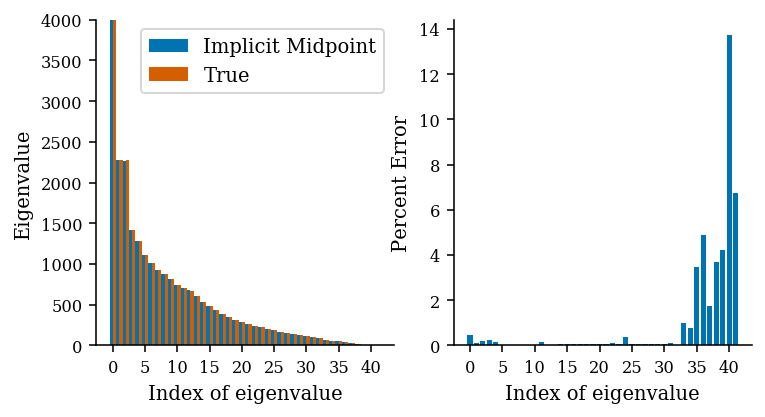

In [245]:
"""Plot of eigenvalue error"""

true_eig = np.sort(np.linalg.eigh(Wp_true)[0])[::-1]
approx_eig = np.sort(np.linalg.eigh(Wp)[0])[::-1]
eig_percent_err = (approx_eig-true_eig)/true_eig*100

fig, ax = plt.subplots(1,2,figsize=(6,3))

x = np.arange(len(eig_percent_err))
barWidth = 0.5
x1 = [r - barWidth/2 for r in x]
x2 = [r + barWidth/2 for r in x]
 
ax[0].bar(x1, approx_eig, width=barWidth, label='Implicit Midpoint')
ax[0].bar(x2, true_eig, width=barWidth, label='True')
ax[0].set_ylim((0,4000))
ax[0].set_xlabel('Index of eigenvalue')
ax[0].set_xticks(x[::5])
ax[0].legend()
ax[0].set_ylabel('Eigenvalue')

ax[1].bar(x,abs(eig_percent_err))
ax[1].set_xlabel('Index of eigenvalue')
ax[1].set_xticks(x[::5])
ax[1].set_ylabel('Percent Error')

In [230]:
q0 = profiles['q'](0)
qa = profiles['q'](1)
theta = theta_grid
eta = 2*np.pi*(theta_grid + straight_field_line_coords['delta_eta'](1,theta_grid)).squeeze()
r = np.sqrt(straight_field_line_coords['r_squared'](1,theta_grid)).squeeze()
delta = straight_field_line_coords['delta_phi'](1,theta_grid).squeeze()
R = ro + r*np.cos(eta)
Z = zo + r*np.sin(eta)

c-----------------------------------------------------------------------
c     write scalars.
c-----------------------------------------------------------------------
      CALL ascii_open(bin_unit,'ahg2msc.out',"UNKNOWN")
      WRITE(bin_unit,'(i4,a)')mtheta,tab//tab//"mtheta"//tab//"mthin"
     $     //tab//"Number of poloidal nodes"
      WRITE(bin_unit,'(i4,a)')mlow,tab//tab//"mlow"//tab//"lmin"//tab
     $     //"Lowest poloidal harmonic"
      WRITE(bin_unit,'(i4,a,a)')mhigh,tab//tab//"mhigh"//tab//"lmax"
     $     //tab//"Highest poloidal harmonic"
      WRITE(bin_unit,'(i4,a)')n,tab//tab//"nn"//tab//"nadj"//tab
     $     //"Toroidal harmonic"
      WRITE(bin_unit,'(f13.10,a)')qa,tab//"qa"//tab//"qa1"//tab
     $     //"Safety factor at plasma edge"
c-----------------------------------------------------------------------
c     write arrays.
c-----------------------------------------------------------------------
      WRITE(bin_unit,'(/a/)')"Poloidal Coordinate Theta:"
      WRITE(bin_unit,'(1p,4e18.10)')(1-theta(itheta),
     $     itheta=mtheta,0,-1)
      WRITE(bin_unit,'(/a/)')"Polar Angle Eta:"
      WRITE(bin_unit,'(1p,4e18.10)')(twopi-angle(itheta),
     $     itheta=mtheta,0,-1)
      WRITE(bin_unit,'(/a/)')"Radial Coordinate X:"
      WRITE(bin_unit,'(1p,4e18.10)')(r(itheta),itheta=mtheta,0,-1)
      WRITE(bin_unit,'(/a/)')"Axial Coordinate Z:"
      WRITE(bin_unit,'(1p,4e18.10)')(z(itheta),itheta=mtheta,0,-1)
      WRITE(bin_unit,'(/a/)')"Toroidal Angle Difference Delta:"
      WRITE(bin_unit,'(1p,4e18.10)')(delta(itheta),
     $     itheta=mtheta,0,-1)
      CALL ascii_close(bin_unit)


In [66]:
alldata[samples[0]]['sing']

array([[0.15056115, 0.15057898, 1.        ],
       [0.59706609, 0.59707075, 2.        ],
       [0.76424727, 0.76424979, 3.        ],
       [0.87216897, 0.87217079, 4.        ],
       [0.95422664, 0.95422755, 5.        ]])

In [28]:
alldata[samples[0]]['sing']

array([[0.15056115, 0.15057898, 1.        ],
       [0.59706609, 0.59707075, 2.        ],
       [0.76424727, 0.76424979, 3.        ],
       [0.87216897, 0.87217079, 4.        ],
       [0.95422664, 0.95422755, 5.        ]])

In [72]:
nn=-1
mpsi = alldata[samples[0]]['mpsi']
profiles = alldata[samples[0]]['profiles']
psi_grid = profiles['psi_grid']
profiles = {key: CubicSpline(profiles['psi_grid'],-val) for key,val in profiles.items()}

In [73]:
profiles

{'psi_grid': <scipy.interpolate._cubic.CubicSpline at 0x7eee707b5af0>,
 'F': <scipy.interpolate._cubic.CubicSpline at 0x7ef5a41f6f10>,
 'P': <scipy.interpolate._cubic.CubicSpline at 0x7ef5a41f64c0>,
 'jac': <scipy.interpolate._cubic.CubicSpline at 0x7ef5a41f6f68>,
 'q': <scipy.interpolate._cubic.CubicSpline at 0x7ef5a41f6308>}

In [86]:
q_extrema = [profiles['q'](psi_grid[0])]
psi_extrema = [psi_grid[0]]
sing_loc = []
sing_m = []

# find extrema of q profile
for i in range(mpsi):
    x0 = psi_grid[i]
    x1 = psi_grid[i+1]
    dx = x1-x0
    y0 = profiles['q'](x0)
    dy0 = profiles['q'](x0,nu=1)
    y1 = profiles['q'](x1)
    dy1 = profiles['q'](x1,nu=1)
    
    A = 6*y0/dx + 3*dy0 - 6*y1/dx + 3*dy1
    B = -6*y0/dx - 4*dy0 + 6*y1/dx - 2*dy1
    C = dy0
    
    det = B**2 - 4*A*C
    if det>0:
        root1 = (-B + np.sqrt(det))/(2*A)
        root2 = (-B - np.sqrt(det))/(2*A)
        for root in [root1, root2]:
            if 0 <= root1 and root1 <= 1:
                x = root*dx + x0
                psi_extrema.append(x)
                q_extrematrema.append(profiles['q'](x))
q_extrema.append(profiles['q'](psi_grid[-1]))
psi_extrema.append(psi_grid[-1])
num_extrema = len(q_extrema)
qmin = np.min(q_extrema)
qmax = np.max(q_extrema)

for i in range(1,num_extrema):
    dq = q_extrema[i] - q_extrema[i-1]
    qlow = np.minimum(q_extrema[i],q_extrema[i-1])
    qhigh = np.maximum(q_extrema[i],q_extrema[i-1])
    
    mlow = np.ceil(qlow*nn)
    mhigh = np.floor(qhigh*nn)
    dm = np.sign(-dq*nn)
    
    for m in np.arange(mlow,mhigh+1,dm):
        def singfun(x):
            return m-nn*profiles['q'](x)
        out = scipy.optimize.root_scalar(singfun,bracket=[psi_extrema[i],psi_extrema[i-1]],xtol=1e-12,rtol=1e-12)
        if out.converged:
            sing_loc.append(out.root)
            sing_m.append(m)
    
    
    
    
    

ValueError: f(a) and f(b) must have different signs

In [85]:
dm

1.0

In [83]:
sing_loc

[]

In [84]:
sing_m

[]

In [43]:
[foo for foo in samples if not np.all(np.diff(alldata[sample]['profiles']['q'])>0)]

[]

In [49]:
mlow = np.min(nn*qmin,0) - 4 - delta_mlow
mhigh = nn*qmax + delta_mhigh
m_grid = np.arange(mlow,mhigh+1)
mpert = mhigh-mlow+1

In [60]:
nn=2